## Preproceso de datos

### Estandarizar variables

Vamos a cargar un conjunto de datos de ventas de casas en King County, USA ([fuente](https://www.kaggle.com/harlfoxem/housesalesprediction))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

house = pd.read_csv('../data/kc_house_data.csv')

In [2]:
house['id'].unique().size

21436

In [3]:
house.shape

(21613, 21)

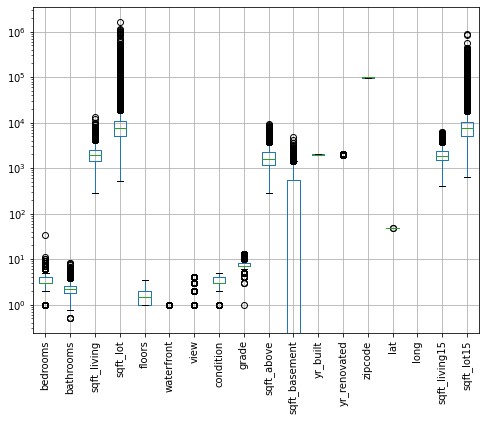

In [4]:
house.drop(columns=['id', 'date', 'price']).boxplot(figsize=(8, 6))
plt.yscale('log')
plt.xticks(rotation=90);

In [5]:
colnames = house.columns.difference(['id', 'date', 'price'])
ncol = 5
nrow = len(colnames) // ncol

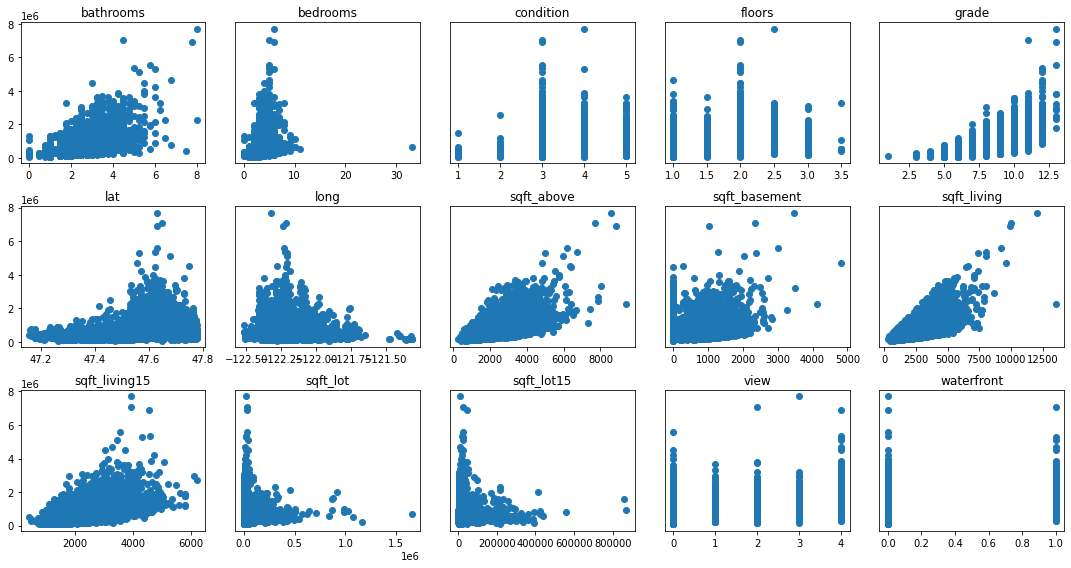

In [6]:
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8))

for idx, (ax, col) in enumerate(zip(axes.ravel(), colnames)):
    ax.scatter(house[col], house['price'])
    if idx % ncol != 0:
        ax.get_yaxis().set_visible(False)
    ax.set_title(col)
fig.tight_layout(h_pad=1)

Muchos modelos de aprendizaje automático requieren que todas las variables tengan rangos similares. De lo contrario unas van a dominar las función objetivo que se optimiza, haciendo que el modelo no aprenda del resto. Un ejemplo son los modelos basados en distancias, como $k$ vecinos próximos. 

La clase `StandardScaler` estandariza cada columna para que tenga media 0 y desviación 1. Todas las funciones de preproceso cuentan con la siguiente API:

   * `fit()`, "ajusta" el modelo
   * `transform()`, realiza la transformación sobre nuevos datos, sin ajustar el modelo
   * `fit_transform()`, realiza ambas operaciones

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

X = house.drop(columns=['id', 'date', 'price'])
y = house['price']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled.mean(axis=0)

array([-1.13974404e-16,  1.35892559e-16,  2.29702260e-16,  7.67135411e-18,
       -1.31508928e-16, -2.19181546e-18, -2.41099701e-17, -1.27563660e-16,
       -2.33209165e-16,  5.95077897e-17, -1.02576964e-16,  3.59545408e-15,
       -3.04662349e-17, -7.59179121e-15, -3.57270304e-14,  1.67831693e-14,
        6.00557436e-17, -1.31508928e-18])

In [10]:
X_test_scaled.mean(axis=0)

array([-0.00983526, -0.02240418, -0.0365069 , -0.00012805, -0.00536255,
       -0.01330878, -0.03556239,  0.00130539, -0.03687058, -0.02742891,
       -0.02464888, -0.0021979 , -0.01756523, -0.01264752, -0.01896943,
       -0.01516592, -0.04490324,  0.01033968])

En este caso "ajustar" el modelo consiste en calcular la media y la desviación de cada una de las columnas. Con `transform` usamos esas medias y desviaciones calculadas para estandarizar los datos, con la siguiente fórmula:

$$\text{col_std} = \frac{\text{col} - \text{media}}{\text{desv}}$$

Es **muy importante** no usar la función `fit_transform` a la hora de escalar los datos de test, ya que cuando el modelo esté en producción no se va a poder calcular para nuevos datos. Por tanto, hay que hacer la transformación con las medias y desviaciones de los datos de entrenamiento con la función `transform`. Podemos ver estas medias y desviaciones que ha calculado el modelo:

In [11]:
scaler.mean_

array([ 3.37312604e+00,  2.11910050e+00,  2.08836924e+03,  1.51082059e+04,
        1.49503362e+00,  7.83515331e-03,  2.41224011e-01,  3.40921710e+00,
        7.66777716e+00,  1.79411660e+03,  2.94252637e+02,  1.97102128e+03,
        8.61839719e+01,  9.80781092e+04,  4.75607085e+01, -1.22213360e+02,
        1.99433784e+03,  1.27021007e+04])

In [12]:
scaler.scale_

array([9.28943621e-01, 7.75315207e-01, 9.27860380e+02, 3.86757268e+04,
       5.40445716e-01, 8.81689497e-02, 7.78307845e-01, 6.50775956e-01,
       1.18278259e+00, 8.34902536e+02, 4.45166080e+02, 2.93851649e+01,
       4.05680138e+02, 5.35663409e+01, 1.38304857e-01, 1.41346757e-01,
       6.93425638e+02, 2.56664689e+04])

Vamos a ver la diferencia de rendimiento del modelo $k$ vecinos proximos con y sin estandarizar las variables:

In [13]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.49278730791739855

In [14]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.7869519231543781

### Otras formas de estandarizar

   * `preprocessing.MinMaxScaler`, escala los datos al intervalo $[0, 1]$
   * `preprocessing.RobustScaler`, escala los datos restando la mediana y dividiendo por el rango entre el primer y tercer cuartiles. Este escalado es más robusto cuando hay valores extremos.
   * `preprocessing.MaxAbsScaler`, escala los datos dividiendo por el máximo valor absoluto. Este escalado no resta la media, y por tanto mantiene los la dispersión de los datos originales (número de 0).

### Variables categóricas

Variables con un número de valores:

   1. discreto
   2. pequeño
   3. conocido
   
La mayoría de modelos no soportan este tipo de variables directamente, ya que requieren una matriz $X$ numérica. Por tanto, siempre que esten presentes tenemos que convertirlas en columnas numéricas.

In [15]:
import seaborn as sns

diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [16]:
diamonds['color'].value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

Como ya vimos, una opción (en general mala) es transformarlas asignando un código numérico a cada categoría:

In [17]:
diamonds['color_ord'] = diamonds['color'].astype('category').cat.codes
diamonds[['color', 'color_ord']].head()

,color,color_ord
0,E,1
1,E,1
2,E,1
3,I,5
4,J,6


In [18]:
pd.Series(diamonds['color'].astype('category').cat.categories)

0    D
1    E
2    F
3    G
4    H
5    I
6    J
dtype: object

Esto es problemático porque:

   1. introduce un orden (generalmente artificial) entre los valores
   2. introduce distancias entre los valores
   
Por ejemplo en el caso de los datos de diamantes el valor "I" está a 1 unidad de distancia de "J" pero a 4 unidades de "E". Sin embargo para otro tipo de variables como "cut", que representan niveles crecientes del corte del diamante, si podría tener sentido esta codificación.

### Codificación *dummy* o *one-hot*

Crea tantas variables binarias (valores 0 o 1) como el número de categorías. Se pueden generar con `pd.get_dummies`:

In [19]:
color_dummy = pd.get_dummies(diamonds['color'])

In [20]:
df = pd.concat((diamonds[['color', 'color_ord']], color_dummy), axis=1)

In [21]:
def highlight_not_zero(s):
    not_zero = s != 0
    return ['background-color: yellow' if v else '' for v in not_zero]
    
df.head(10).style.apply(highlight_not_zero, subset=['D', 'E', 'F', 'G', 'H', 'I', 'J'])

,color,color_ord,D,E,F,G,H,I,J
0,E,1,0,1,0,0,0,0,0
1,E,1,0,1,0,0,0,0,0
2,E,1,0,1,0,0,0,0,0
3,I,5,0,0,0,0,0,1,0
4,J,6,0,0,0,0,0,0,1
5,J,6,0,0,0,0,0,0,1
6,I,5,0,0,0,0,0,1,0
7,H,4,0,0,0,0,1,0,0
8,E,1,0,1,0,0,0,0,0
9,H,4,0,0,0,0,1,0,0


Esta codificación es redundante en el sentido de que una de las columnas queda determinada por completo a partir de las otras. Por ejemplo, la columna J solo tiene valor* uno cuando el resto de columnas tienen **todas** valor 0. Esto puede empeorar el rendimiento de modelos que tienen problemas con variables muy correladas.

La función `get_dummies` tiene un parámetro que elimina automáticamente una de estas columnas (la primera). En general no es importante cual se elimine, pero a veces si relevante para interpretar el modelo resultante.

In [22]:
pd.get_dummies(diamonds['color'], drop_first=True).head()

,E,F,G,H,I,J
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,1


### Variables categóricas en scikit-learn

Las dos ténicas anteriores están implementadas en el módulo `preprocessing` de scikit-learn:

   1. `preprocessing.OneHotEncoder`: codificación dummy o one-hot
   2. `preprocessing.OrdinalEncoder`: codificación ordinal

In [23]:
from sklearn.preprocessing import OneHotEncoder

diamonds = sns.load_dataset('diamonds')

encoder = OneHotEncoder()
X = encoder.fit_transform(diamonds)

In [24]:
X

<53940x13687 sparse matrix of type '<class 'numpy.float64'>'
	with 539400 stored elements in Compressed Sparse Row format>

**Ojo**: la clase `OneHotEncoder` aplica sobre **todas** las columnas. 

Para realizar una operación sobre unas columnas y no otras tenemos que usar la clase `sklearn.compose.ColumnTransformer`, que permite aplicar distintas transformaciones a distintas columnas/grupos de columnas:

<img src=https://amueller.github.io/ml-workshop-1-of-4/slides/images/column_transformer_schematic.png width=600>

In [25]:
diamonds['cut'].value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

col_trans = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include='number')),
    (OneHotEncoder(drop='first'), ['color', 'clarity']),
    (OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']]), ['cut'])
)

In [27]:
X = col_trans.fit_transform(diamonds)
X.shape

(53940, 21)

In [28]:
col_trans.transformers_

[('standardscaler',
  StandardScaler(),
  ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']),
 ('onehotencoder', OneHotEncoder(drop='first'), ['color', 'clarity']),
 ('ordinalencoder',
  OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']]),
  ['cut'])]

In [29]:
col_trans.transformers_[2][1].categories_

[array(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], dtype=object)]

In [30]:
diamonds.shape

(53940, 10)

In [31]:
diamonds.describe(exclude='number')

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


¿Por qué el resultado tiene 23 columnas?

#### Modelos que soportan variables categóricas

Teóricamente, todos los modelos basados en árboles y naive Bayes soportan variables categóricas sin necesidad de transformarlas a variables continuas. Sin embargo, por motivos de eficiencia no es común implementarlos de esta forma. 

Actualmente en scikit-learn solo soportan variables categóricas directamente los modelos naive Bayes.

Se prevé que en próximas versiones los árboles de decisión, *random forest* y *gradient boosting* soporten variables discretas. Otras implementaciones no incluidas en scikit-learn (las veremos más adelantes si las soportan), como por ejemplo CatBoost, si cuentan con este soporte. 

### Ejercicios

#### Ejercicio 1

Con los datos del conjunto de datos de iris: 

   * Cargar los datos usando `sklearn.dataset.load_iris`
   * Separar en train-test
   * Ajustar un modelo de $k$ vecinos próximos sobre los datos estandarizados y sin estandarizar. ¿Cuál es la diferencia de rendimiento?


#### Ejercicio 2

Vamos a trabajar ahora con datos de propinas, que vienen incluidos en la librería `seaborn`. El nombre del conjunto de datos es `tips`, y contiene información sobre distintas variables que pueden tener influencia en las propinas:

   * Cargar el conjunto de datos
   
   * Ver el tipo de cada una de las columnas
   
   * Hacer alguna visualización para ver como se relacionan el resto de variables con la columna `tip` (por ejemplo usando las funciones `sns.pairplot` y `sns.catplot`)
   
   * De las columnas categóricas, ¿qué codificación tiene sentido usar para cada una de ellas?
   
   * Estandarizar las columnas numéricas y realizar la transformación correspondiente para cada una de las variables categóricas